### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import os
import time
import cv2 # Image handling library
import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [67]:
def plot_model(history):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    epochs = len(history['epoch_losses'])
    # summarize history for accuracy
    axs[0].plot(np.arange(1, epochs + 1), history['epoch_acc'], 'c', label='Train accuracy')
    axs[0].plot(np.arange(1, epochs + 1), history['epoch_val_acc'], 'm', label='Test accuracy')
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(loc='lower right')
    axs[0].grid(color='lightgrey')
    # summarize history for loss
    axs[1].plot(np.arange(1, len_l + 1), history['epoch_losses'], 'c', label='Train loss')
    axs[1].plot(np.arange(1, len_l + 1), history['epoch_val_losses'], 'm', label='Test loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].grid(color='lightgrey')
    plt.show()

### Пути к директориям и файлам

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# dst_path = '/content/drive/MyDrive/Colab Notebooks/my_projects/archive.zip'

### Загрузка данных

In [8]:
# from zipfile import ZipFile
# zipfile = ZipFile(dst_path)
# zipfile.extractall()

In [9]:
CATEGORIES = ['01_palm', '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']

In [10]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами. 
# glob.glob(pathname) возвращение список (возможно, пустой) путей, соответствующих шаблону pathname.
images = glob.glob('D:/kaggle/leapGestRecog/**/**/*.png')
# images = glob.glob('/content/leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
label = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [11]:
train_transformer = transforms.Compose([
                    transforms.Resize((48, 128)),                # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),           # randomly flip image horizontally
                    transforms.ToTensor()])                      # transform it into a PyTorch Tensor

test_transformer = transforms.Compose([
                   transforms.Resize((48, 128)),                 # resize the image to 64x64 
                   transforms.Grayscale(num_output_channels=1),  # returned image is single channel
                   transforms.ToTensor()]) 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size = 0.3, random_state=42)

In [13]:
class SIGNSDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [14]:
train_dataset = SIGNSDataset(X_train, y_train, train_transformer)
test_dataset = SIGNSDataset(X_test, y_test, test_transformer)

In [15]:
batch_size = 32
lr = 0.01
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

### Визуализация данных

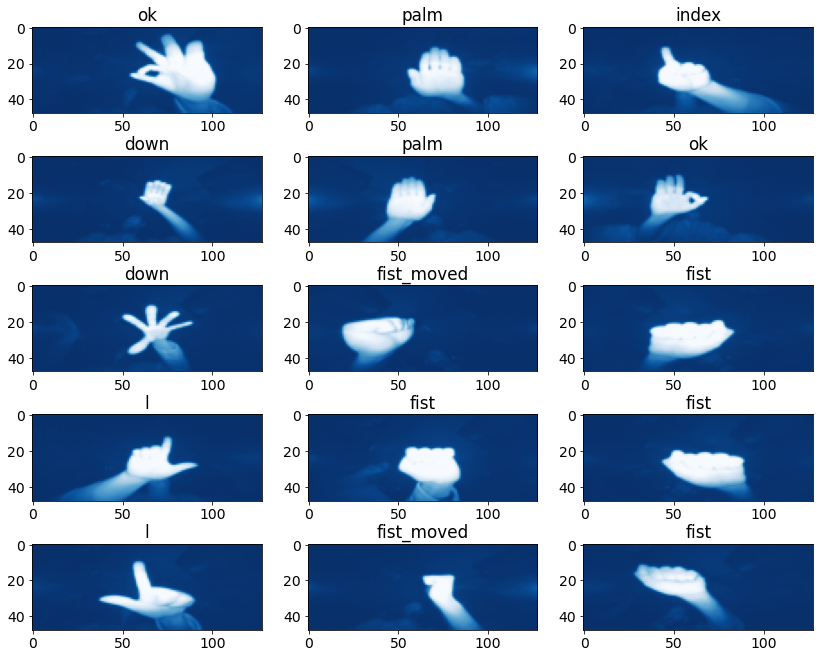

In [16]:
data_iter = iter(train_dl)

img, labels = data_iter.next()

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    plt.imshow(img[i, 0, :, :], cmap='Blues_r')
    plt.title(f'{CATEGORIES[int(labels[i])][3:]}')
    if i > 13:
        break

### Создание модели

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(32*22*62, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [18]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [19]:
epochs = 20

In [20]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 438 total_steps per epoch


### Обучение модели

In [21]:
def fit(model, epochs):
    
    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20

    
    # Print model's state_dict        
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print('\t', param_tensor,': ', model.state_dict()[param_tensor].size())

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        # print(f'Epochs: {epoch+1}')
        time1 = time.time()
        model.train()
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(test_dl, 0):
                inputs, labels = data
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f'Epochs: {epoch+1}   loss: {epoch_losses[-1]:.5f}   '
              f'accuracy: {epoch_acc[-1]*100:.3f}%   '
              f'loss_val: {epoch_val_losses[-1]:.5f}   '
              f'accuracy_val: {epoch_val_acc[-1]*100:.3f}%   '
              f'time = {time2-time1:.2f} s')
        
    return {'epoch_losses': epoch_losses, 
            'epoch_val_losses': epoch_val_losses, 
            'epoch_acc': epoch_acc, 
            'epoch_val_acc': epoch_val_acc}

In [22]:
history = fit(model, epochs)

State_dict модели: 
	 conv1.weight :  torch.Size([32, 1, 3, 3])
	 conv1.bias :  torch.Size([32])
	 conv2.weight :  torch.Size([32, 32, 3, 3])
	 conv2.bias :  torch.Size([32])
	 fc1.weight :  torch.Size([128, 43648])
	 fc1.bias :  torch.Size([128])
	 fc2.weight :  torch.Size([10, 128])
	 fc2.bias :  torch.Size([10])
Эпоха: 1   loss: 1.74909   accuracy: 39.847%   loss_val: 1.12054   accuracy_val: 66.689%   time = 475.31 c
Эпоха: 2   loss: 0.71339   accuracy: 76.313%   loss_val: 0.60643   accuracy_val: 81.366%   time = 246.45 c
Эпоха: 3   loss: 0.29093   accuracy: 90.682%   loss_val: 0.11456   accuracy_val: 96.925%   time = 247.07 c
Эпоха: 4   loss: 0.14567   accuracy: 95.869%   loss_val: 0.07625   accuracy_val: 97.590%   time = 271.03 c
Эпоха: 5   loss: 0.14686   accuracy: 96.040%   loss_val: 0.04646   accuracy_val: 98.604%   time = 264.42 c
Эпоха: 6   loss: 0.09421   accuracy: 97.539%   loss_val: 0.04995   accuracy_val: 98.753%   time = 266.73 c
Эпоха: 7   loss: 0.06065   accuracy: 98.5

### Сохранение модели

In [25]:
# torch.save(model.state_dict(), '/content/hand_gesture_recognitionemotion.pth')
torch.save(model.state_dict(), 'data/hand_gesture_recognitionemotion.pth')

### Загрузка модели

In [22]:
net = Net().to(device)
# net.load_state_dict(torch.load('/content/hand_gesture_recognitionemotion.pth'))
net.load_state_dict(torch.load('data/hand_gesture_recognitionemotion.pth', map_location=torch.device('cpu')))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=43648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Результаты

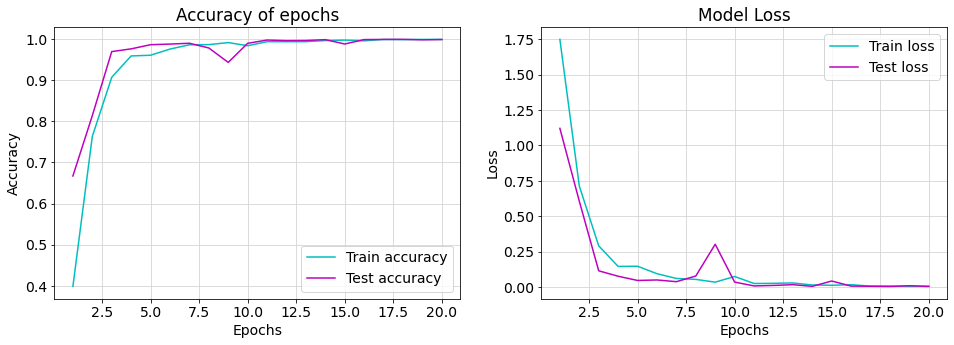

In [68]:
plot_model(history)

correct: 32 / 32


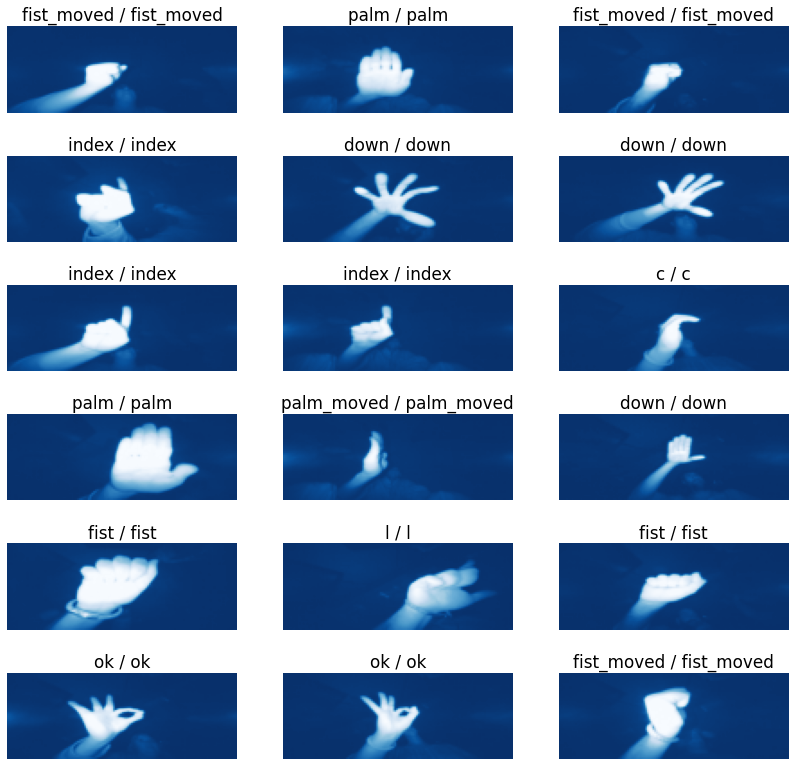

In [89]:
data_iter = iter(test_dl)

img, labels = data_iter.next()

# print(f'labels: {labels}')

model.eval()
with torch.no_grad():
    inputs = img.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # Отслеживание точности
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
#     print(f'predicted: {predicted}')
    correct = (predicted == labels).sum().item()
    print(f'correct: {batch_size} / {correct}')

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    
    plt.imshow(img[i, 0, :, :], cmap='Blues_r')
    if int(labels[i]) == int(predicted[i]):
        plt.title(f'{CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    else:
        plt.title(f'Error: {CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    plt.axis('off')
    if i > 16:
        break

### Face Detection application using PyTorch and OpenCV

In [25]:
from facenet_pytorch import MTCNN

In [149]:
# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, net):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = net

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion, gesture, commands):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (255, 255, 0),
                              thickness=2)

                # Пишем на кадре какая эмоция распознана
                cv2.putText(frame, emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except Exception as e:
#             print('Something wrong im draw function!')
#             print(f'error : {e}')
            pass

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces
    
    @staticmethod
    def CATEGORIES(digit):
        if digit == 1:
            return '01_palm' 
        elif digit == 2:
            return '02_l'
        elif digit == 3:
            return '03_fist'
        elif digit == 4:
            return '04_fist_moved'
        elif digit == 5:
            return '05_thumb'
        elif digit == 6:
            return '06_index'
        elif digit == 7:
            return '07_ok' 
        elif digit == 8:
            return '08_palm_moved'
        elif digit == 9:
            return '09_c'
        elif digit == 10:
            return '10_down'

       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # Детектируем расположение лица на кадре, вероятности на сколько это лицо и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                if probs[0]: # если лицо есть
                    gframe = cv2.resize(frame[..., 0], (48, 128)) # фрейм меняет размер [48, 128]
                    # Превращаем в 1-канальное серое изображение
#                     gframe = cv2.cvtColor(gframe, cv2.COLOR_BGR2GRAY)
                    # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
#                     gframe = torch.from_numpy(gframe).unsqueeze(0).to(self.device).float()
                    gframe = torch.from_numpy(gframe) # переводится в тип tensor
                    gframe = gframe[None, None].float() # добаляются еще 2 мерности и значения переводятся в тип float
                    # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                    gesture = self.emodel(gframe)
#                     gesture = self.emodel(gframe)[0] # прогноз модели
#                     gesture = self.CATEGORIES[gesture.argmax()] # название жеста
                    gesture = self.CATEGORIES(gesture[0].argmax().item())
                    cv2.putText(frame, 'gesture - ' + gesture, (5, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 204), 2, cv2.LINE_AA)
        
                    commands = gesture      
                    if commands == '09_c':
                        cv2.putText(frame, 'Screenshot saved', (5, 460), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 204), 2, cv2.LINE_AA)
                        cv2.imwrite('screenshot.png', frame)   
                    elif commands == '08_palm_moved':
                        cv2.putText(frame, 'No gesture command assigned', (0, 460), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 204), 2, cv2.LINE_AA)                   
         
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48, 128))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
#                 emotion = self.CATEGORIES(emotion[0].argmax().item())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion, gesture, commands)
                
#                 cv2.imshow('Gray face', face)

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [150]:
# Загружаем MTCNN
mtcnn = MTCNN()

# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, net)

# Запускаем
fcd.run()

<ipython-input-149-da38dbfb6aef>:16: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(frame,


![image](data/gesture.jpeg)  